# Problem Set 3. Transitions for Hugget: Debt and Pareto Improvements

Problem Set 3 from Manuel Amador ECON 8108

Python 3.8.2

Xiang Liu

This code originally from Adam. I try to understand it as much as I could and replicate it. Self comments are made in the code. Under a lot of help of Adam and Xing. Thanks a lot!

## Initial setup 

In [51]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
import numba as nb
from numba.typed import Dict
import time

## Parameters

In [52]:
# Preferences 

beta = 0.95                    # Discount factor as usual
rho = 2                        # Risk aversion parameter

# Assets 

phi = 0                        # Borrowing limit is zero as given in a special case of Hugget model
a_min = 0                      # Min assets
a_max = 15                     # Max assets - guess
n_asset_gridpoints = 10000     # Number of grid points for the asset holdings is 10,000
a_grid = np.linspace(a_min, a_max, n_asset_gridpoints)         # Grid for assets

# Shocks 

n_shocks = 2                   # We have two endowment shocks here
y = np.array([0.5, 1.0])       # Endowment shocks are given by this array
p = np.array([[.5, .5],        # Transition matrix for the endowment shocks
                [0.2, 0.8]])

# Transition 

T = 100

## Utility functions

In [53]:
# The utility function and its derivative is given by 
# (Make sure it is well-defined, here we have rho = 2, so no worries about that)

# Utility function:

@nb.jit(nopython=True)
def u(c):
    if rho != 1:
        return c ** (1 - rho) / (1 - rho)
    return np.log(c)

# U':

@nb.jit(nopython=True)
def uprime(c):
    if rho != 1:
        return 1 / (c ** rho)
    return 1 / c



## Computing value function

The following function - iterate_value - computes the value function and the policy function from the HH problem.

In [54]:
@nb.jit(nopython=True)
def iterate_value(v0, bigR, T=0, tol=1e-20, max_iters=1000, warn=True):
    
    # Inputs of the fucntion: the guessed value function, the exogenous interest rate bigR, 
    # transfer (here T = 0 is for computing the part where you add transfers back in, but one does not to write that code, 
    # tolerance, max iteration times, and a warn that indicates that the value function iteration did not converge 
    # to the given tolerance within the maximum number of iterations. 
    
    # Now, we initialize vectors/values:
    
    v1 = np.zeros((n_asset_gridpoints, n_shocks))                     # value function 1, all zeroes
    pol1 = np.zeros((n_asset_gridpoints, n_shocks), dtype=np.int32)   # policy function 1, all zeroes
    beta_v_exp = np.zeros((n_asset_gridpoints, n_shocks))             # \beta * E[v], all zeroes
    distance = tol                                                    # will use it later
    iter = 0                                    

    # Conduct value function iteration:
    
    while (distance >= tol) and (iter < max_iters):
        #Update the time of iterations:
        iter += 1
        
        # Pre-compute the expected value term:
        for s_idx in range(n_shocks):
            for a_prime_idx in range(n_asset_gridpoints):
                beta_v_exp[a_prime_idx, s_idx] = 0
                for s_prime_idx in range(n_shocks):
                    beta_v_exp[a_prime_idx, s_idx] += p[s_idx, s_prime_idx] * v0[a_prime_idx, s_prime_idx]
                beta_v_exp[a_prime_idx, s_idx] *= beta
                
         # beta_v_exp = beta * (p[None, :, :] * v0[:, :, None]).sum(axis=2)
         # it is clear if one just look at the last term of the value function, \beta*E[v()]
        
         # Iterate over shocks:
        for s_idx in range(n_shocks):
            
            policy_idx = 0     # keep track of policy function starting from here 
            
            # For any given shock indexed by s_idk, iterate over assets:
            for a_idx in range(n_asset_gridpoints): 
                vmax = -np.inf
                a_prime_idx = policy_idx             # we start from the previous optimal policy since the policy function of monotonic
                
                # For given current assets and shock, iterate over choices for the possible assets for next period：
                while a_prime_idx < n_asset_gridpoints:
                    c = bigR * a_grid[a_idx] + y[s_idx] - a_grid[a_prime_idx] + T   # resource constraint
                    if c > 0:
                        v_a_prime = u(c) + beta_v_exp[a_prime_idx, s_idx]
                        if v_a_prime > vmax:
                            vmax = v_a_prime
                            policy_idx = a_prime_idx
                        else:
                            # that is, the value decreased, however, since we have concavity, it can't increase after that
                            break
                    elif a_prime_idx == n_asset_gridpoints - 1:
                        # Note: cannot raise errors with Numba ?
                        raise ValueError("No valid choices for a'.")
                    a_prime_idx += 1
                    
                # Update the initial value function and policy function using the coordinate [a_idx, s_idx] under the loop:
                v1[a_idx, s_idx] = vmax
                pol1[a_idx, s_idx] = policy_idx

        # Compute the distance in order to campare it with the tolerance we set at the beginning later:
        distance = np.max(np.abs(v1 - v0))
        
        # Swap v0 and v1 if (distance >= tol) and (iter < max_iters):
        if (distance >= tol) and (iter < max_iters):
            temp = v0
            v0 = v1
            v1 = temp
        # Iterate!
        
        
        # This is how 'warn' works:
    if (iter == max_iters) and (distance >= tol) and warn:
        print(f'Warning: value function iteration did not converge to the given tolerance within the maximum number of iterations.')

    return v1, pol1

## Computing stationary distribution

The following functions provides the stationary distribution. 

In [55]:
@nb.jit(nopython=True)

def iterate_distribution(pdf0, policy):
    
    # First, let's initialize vectors/values, the initial pdf:
    pdf1 = np.zeros((n_asset_gridpoints, n_shocks))

    # Iterate over assets: 
    for a_idx in range(n_asset_gridpoints):
        
        # For a given assets indexed by a_idk in the loop, iterate over shocks:
        for s_idx in range(n_shocks):
            
            # For given asset (indexed by a_idk) and shock (indexed by s_idk), iterate over the shocks in next period:
            for s_prime_idx in range(n_shocks):
                pdf1[policy[a_idx, s_idx], s_prime_idx] += p[s_idx, s_prime_idx] * pdf0[a_idx, s_idx]
                # the equation above is to update pdf, the distribution of wealth, like the equation given by the lecture: 
                # \lambda_{t+1}(a',s') = \sum_{s} \sum_{a: g(a,s) = a'} \pi(s'|s) \lambda_{t}(a,s)

    return pdf1

@nb.jit(nopython=True)

# The function below, get_stationary_distribution, takes an initial pdf and iterates using the policy 
# function to obtain the stationary distribution 

def get_stationary_distribution(pdf0, policy, tol=1e-20, max_iters=1000):
    
    # First, initialize vectors/values:
    pdf1 = np.zeros((n_asset_gridpoints, n_shocks))
    distance = tol
    iter = 0

    while (distance >= tol) and (iter < max_iters):
        
        # Update the time of iterations here:
        iter += 1 
        
        # Stationary distribution iteration:
        # Iterate over assets first:
        for a_idx in range(n_asset_gridpoints):
            
            # For the given assets indexed by a_idk, iterate over shocks:
            for s_idx in range(n_shocks):
                
                # For the given asset (indexed by a_idk) and the shock (indexed by s_idk), iterate over the shocks of the next period:
                for s_prime_idx in range(n_shocks):
                    pdf1[policy[a_idx, s_idx], s_prime_idx] += p[s_idx, s_prime_idx] * pdf0[a_idx, s_idx]
                    # the equation above is to update pdf, the distribution of wealth, like the equation given by the lecture: 
                    # \lambda_{t+1}(a',s') = \sum_{s} \sum_{a: g(a,s) = a'} \pi(s'|s) \lambda_{t}(a,s)

        # Compute the distance so far in order to campare it with the tolerance later
        distance = np.max(np.abs(pdf1 - pdf0))

        # Swap pdf0 and pdf1 and repeats:
        if (distance >= tol) and (iter < max_iters):
            
            temp = pdf0
            pdf0 = pdf1
            pdf1 = temp
            pdf1[:] = 0

    if (iter == max_iters) and (distance >= tol):
        raise ValueError(f'Stationary distribution iteration did not converge to the given tolerance within the maximum number of iterations.')
    
    return pdf1

## Computing asset distribution transition (forwards iteration)

This is the function of forwards iteration for computing the asset distribution trasition. We will use it later. 

In [56]:
def compute_transition_assets(pdf1, pdf2, policy_path):
    
    # First, initailize the transition path with zeros in the shape of (T + 1, n_asset_gridpoints, n_shocks), that is,
    # in each period, we have a transition of the shape of (n_asset_gridpoints, n_shocks).
    
    transition_path = np.zeros((T + 1, n_asset_gridpoints, n_shocks))
    
    # Start from this one, in the eq'm 'A', as mentioned in class:
    transition_path[0, :, :] = pdf1  
    
    # Ends with this one, in the eq'm 'B', and we're interested in the path from 'A' to 'B':
    transition_path[T, :, :] = pdf2  
    
    for t in range(T - 1):
        if len(policy_path.shape) == 2:
            # If policy is the same over time
            policy_t = policy_path
        else:
            # If policy changes over time
            policy_t = policy_path[t, :, :]
            
        # Iterate policy forward one period, and here we use the function of iterare distribution:
        transition_path[t + 1, :, :] = iterate_distribution(transition_path[t, :, :], policy_t)

    return transition_path

## Computing value and policy function transition (backwards iteration)

This is the function of backwards iteration for computing the value function and policy function trasitions. We will use it later. 

In [57]:
def compute_transition_value_policy(bigR, value2, policy2, transfers_path):
    
    # First, initialize the value path and the policy path with zeros in the shape of (n_asset_gridpoints, n_shocks) 
    # in each period in the trasition: 
    value_path = np.zeros((T + 1, n_asset_gridpoints, n_shocks))
    policy_path = np.zeros((T + 1, n_asset_gridpoints, n_shocks), dtype=np.int32)

    # In eq'm 'B', the final point of the transition path, we have: 
    value_path[T, :, :] = value2
    policy_path[T, :, :] = policy2


    for t in range(T):
        
        t_adj = T - t - 1
        value_tplus1 = value_path[t_adj + 1, :, :]
        
        # Setting max_iters=1 is equivalent to optimizing given that v_{t+1} is known
        # For each period t in range(T), we use the value function iteration to get the 
        # value function and the policy function in t by plugging in the value function or period t+1:
        value_t, policy_t = iterate_value(value_tplus1, bigR, T=transfers_path[t_adj], tol=1e-4, max_iters=1, warn=False)
        
        # Update the value path and the policy path:
        value_path[t_adj, :, :] = value_t
        policy_path[t_adj, :, :] = policy_t

    return value_path, policy_path


## Computing full transition

Here, we use the following function to compute the full trasition. We will use it to do policy analysis later. 

In [58]:
def compute_full_transition(R1, R2, T_frac=1, tol=1e-20, max_iters=1000):
    
    ### Let's compute the initial stationary distributions:
    
    ##  Computing the solution to the HH's problem 1 (R1):
    
    #   Initialization:
    v0 = np.zeros([n_asset_gridpoints, n_shocks])
    
    t = time.time()
    
    # Use our function of value function iteration (with inputs of v0 and R1) defined above 
    # to get the corresponding value and policy functions:
    valueR1, policyR1 = iterate_value(v0, R1)
    print(f'VFI: {time.time() - t} seconds')

    ## Then, we have the stationary distribution of problem 1 (R1):
    #  Initialization:
    pdf0 = np.ones((n_asset_gridpoints, n_shocks)) / (n_asset_gridpoints * n_shocks)
    t = time.time()
    
    # Recall our function of getting the stationary distribution here to get the stationary
    # distribution with inputs of pdf0 and policyR1 we get above:
    pdf_ssR1 = get_stationary_distribution(pdf0, policyR1)
    print(f'Stationary distribution: {time.time() - t} seconds')
    pdf_assetsR1 = pdf_ssR1.sum(axis=1)

    ## Computing the solution to the HH's problem 2 (R2): 
    #  Initialization:
    v0 = np.zeros([n_asset_gridpoints, n_shocks])
    t = time.time()
    
    # Use our function of value function iteration (with inputs of v0 and R2) defined above 
    # to get the corresponding value and policy functions:
    valueR2, policyR2 = iterate_value(v0, R2)
    print(f'VFI: {time.time() - t} seconds')

    ## Computing the stationary distribution 2 (R2):
    #  Initialization:
    pdf0 = np.ones((n_asset_gridpoints, n_shocks)) / (n_asset_gridpoints * n_shocks)
    t = time.time()
    
    # Recall our function of getting the stationary distribution here to get the stationary
    # distribution with inputs of pdf0 and policyR2 we get above:
    pdf_ssR2 = get_stationary_distribution(pdf0, policyR2)
    print(f'Stationary distribution: {time.time() - t} seconds')
    pdf_assetsR2 = pdf_ssR2.sum(axis=1)



    ## Initial guess for policy path without transfers:
    policy_path = policyR2


    ### First iteration:
    #   guess initial path of transfers
    
    # Recall the function (compute_transition_assets) we defined to compute transition along policy path 
    # with inputs of pdf_ssR1, pdf_ssR2, and the guessed policy path:
    transition_path_assets1 = compute_transition_assets(pdf_ssR1, pdf_ssR2, policy_path)

    # The aggregate savings is given by summing over the grid of assets/wealth distribution times the coresponding transition:
    transition_pdf_assets = transition_path_assets1.sum(axis=2)
    transition_assets = np.sum(a_grid[None, :] * transition_pdf_assets, axis=1)

    # The wasted resources is given by:
    wasted_resources = transition_assets[1:] - R2 * transition_assets[: -1]

    # Guess for transfers, where we assumethat all wasted resources are transferred, 
    # i.e. T_frac = 1 as given in the argument of this function (compute_full_transition):
    transition_transfers1 = T_frac * wasted_resources

    # Update the previous values, and we will use it to calculate error/distance:
    transition_path_assets0 = transition_path_assets1
    transition_transfers0 = transition_transfers1

    ## Iterations from here:
    #  setup
    dist = tol
    iter = 0
    
    while (dist >= tol) and (iter < max_iters):
        iter += 1
        print(f'Iteration: {iter}')
        
        # Conduct the backwards iteration to compute value and policy functions by the function 
        # compute_transition_value_policy given R2, valueR2, policyR2, and transition_transfers1:
        value_path, policy_path = compute_transition_value_policy(R2, valueR2, policyR2, transition_transfers1)

        # Then we iterate again (forwards iteration) to compute asset distribution transition: 
        transition_path_assets1 = compute_transition_assets(pdf_ssR1, pdf_ssR2, policy_path)

        # Use the asset distribution transition we get just now to calculate the new path of transfers bythe following three steps:
           # 1. calculating the aggregate savings:
        transition_pdf_assets = transition_path_assets1.sum(axis=2)
        transition_assets = np.sum(a_grid[None, :] * transition_pdf_assets, axis=1)

           # 2. calculating the wasted resources:
        wasted_resources = transition_assets[1:] - R2 * transition_assets[: -1]

           # 3. finally, the transfers:
        transition_transfers1 = T_frac * wasted_resources

        # Calculate the distance by choosing the larger one:
        dist1 = np.max(np.abs(transition_path_assets1 - transition_path_assets0))
        dist2 = np.max(np.abs(transition_transfers1 - transition_transfers0))
        dist = max(dist1, dist2)

        # Update previous values
        transition_path_assets0 = transition_path_assets1
        transition_transfers0 = transition_transfers1

    if (iter == max_iters) and (distance >= tol): #??? dist?
        print(f'Warning: transition path iteration did not converge to the given tolerance within the maximum number of iterations.')

    return value_path, policy_path, transition_path_assets1

Based on the functions defined above: 

    $iterate\_value$: value function iteration;

    $iterate\_distribution \& get\_stationary\_distribution$: stationary distribution ;

    $compute\_transition_assets$: asset distribution transition by forward iteration; 

    $compute\_transition\_value\_policy$: value and policy function transition by backwards iteration;

    $compute\_full/_transition$: full transition given two interest rates;

we can do problem 1. 

## Part a

In [59]:
R_bar = np.min(uprime(y) / (p * uprime(y[None, :])).sum(axis=1)) / beta

R_bar

0.6578947368421053

$\bar{R} \approx 0.658$.

## Part b

In [60]:
# Take R_bar from part (a) as given, and we use the function for value function iteration first, 
# and then use the function (takes policy function we get as input) that provides the stationary distribution
# Initialization:
v0 = np.zeros([n_asset_gridpoints, n_shocks])
t = time.time()

# VFI:
value1, policy1 = iterate_value(v0, R_bar)

print(f'VFI: {time.time() - t} seconds')

# Stationary distribution:
pdf0 = np.ones((n_asset_gridpoints, n_shocks)) / (n_asset_gridpoints * n_shocks)
t = time.time()
pdf_ss1 = get_stationary_distribution(pdf0, policy1)
print(f'Stationary distribution: {time.time() - t} seconds')
pdf_assets1 = pdf_ss1.sum(axis=1)

VFI: 1.3819589614868164 seconds
Stationary distribution: 0.8454930782318115 seconds


Plotting the Stationary distribution over assets:

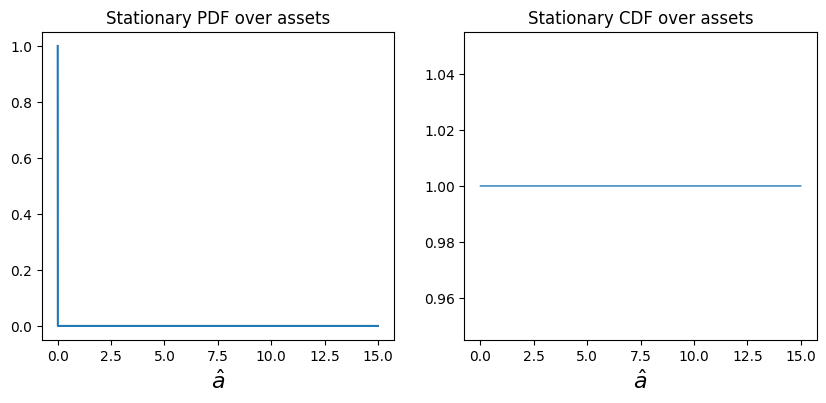

In [61]:
# Plotting:
# PDF:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(a_grid, pdf_assets1)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary PDF over assets');

# CDF:
plt.subplot(122)
plt.plot(a_grid, np.cumsum(pdf_assets1), lw = 1)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary CDF over assets');

The plots we get make sense. 

$\bar{R}$ is the highest interest rate we can get by the definition or $\bar{r}$. Under $\bar{R}$, the richest consumer or the group of the richest consumer will not save. Thus, no one will save. Also, as $\phi = 0$ given, there's no borrowing as well. Therefore, it is possible for us to has this situation in equilibrium with the zero aggregate asset, this is autarky. 

We are going to assume that we start from the stationary equilibrium described in part (b). Next, we are going to introduce a government that issues debt and lump-sum transfers to households.

## Part c

Let us first compute the new stationary equilibrium.

In [62]:
# Given R' = 1
R_prime = 1

# Solve the household problem by using the VFI:
v0 = np.zeros([n_asset_gridpoints, n_shocks])
t = time.time()
value2, policy2 = iterate_value(v0, R_prime)
print(f'VFI: {time.time() - t} seconds')

# Stationary distribution:
pdf0 = np.ones((n_asset_gridpoints, n_shocks)) / (n_asset_gridpoints * n_shocks)
t = time.time()
pdf_ss2 = get_stationary_distribution(pdf0, policy2)
print(f'Stationary distribution: {time.time() - t} seconds')
pdf_assets2 = pdf_ss2.sum(axis=1)

VFI: 1.3813390731811523 seconds
Stationary distribution: 0.1315457820892334 seconds


The Stationary distribution over assets:

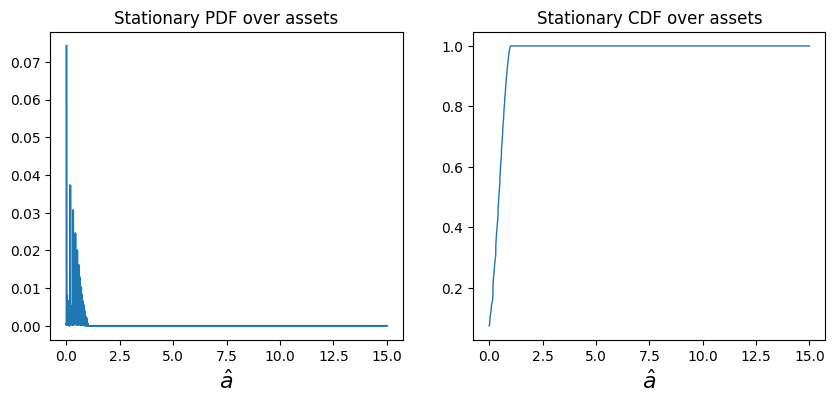

In [63]:
# Plotting:
# PDF:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(a_grid, pdf_assets2)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary PDF over assets');

# CDF:
plt.subplot(122)
plt.plot(a_grid, np.cumsum(pdf_assets2), lw = 1)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary CDF over assets');

## Part d

Use the asset market clearing condition to compute the level of debt that the government must be issuing in this stationary equilibrium

 The asset market clearing condition in stationary equilibrium is given by  
 
 $$B = \sum_{a, s} \lambda(a,s)g(a,s).$$

In [64]:
B_prime = np.sum(a_grid * pdf_assets2)

B_prime

0.44633499614440286

$B \approx 0.446$ in the stationary equilibrium.

## Part e

We have the government budget constraint, $B_{t+1} - R_t B_t \geq T_t$, with $T_t = 0$ in stationary equilibrium. The wasted resources are $B_{t+1} - R_t B_t$. In the stationary eq'm, we have $B_{t+1} = B_{t} = B$, and $R_t = R' = 1$, for all $t$. 

Thus, we have 

$$ B_{t+1} - R_t B_t = (1-R')B = 0.$$

So there's no resources lost in the new stationary equilibrium. This is easy to show in codes: 

In [65]:
T_prime = (1 - R_prime) * B_prime
T_prime

0.0

## Part f

If $\bar{R} < R' < 1$, then in the stationary equilibrium, the resource lost is given by
$$
    B_{t+1} - R_t B_t = (1-R')B > 0,
$$

where $B > 0$ since  $R' > \bar{R}$ implies that increase in the interest rate will cause more savings in the new equilibrium.

So $(1-R') > 0$ and $B > 0$, so in the equilibrium where $\bar{R} < R' < 1$, resources will be wasted.

We give a numerical example:

In [66]:
#Set R'' s.t \bar{R} < R'' < 1

R_prime_prime = 0.8

# Solve the HH's problem by VFI:
v0 = np.zeros([n_asset_gridpoints, n_shocks])
t = time.time()
value3, policy3 = iterate_value(v0, R_prime_prime)
print(f'VFI: {time.time() - t} seconds')

# Stationary distribution:
pdf0 = np.ones((n_asset_gridpoints, n_shocks)) / (n_asset_gridpoints * n_shocks)
t = time.time()
pdf_ss3 = get_stationary_distribution(pdf0, policy3)
print(f'Stationary distribution: {time.time() - t} seconds')
pdf_assets3 = pdf_ss3.sum(axis=1)

# Government debt: B'' = \sum_{a, s} \lambda(a,s)g(a,s)
B_prime_prime = np.sum(a_grid * pdf_assets3)

# Then the transfers, the resource lost:
T_prime_prime = (1 - R_prime_prime) * B_prime_prime
T_prime_prime

VFI: 0.19998908042907715 seconds
Stationary distribution: 0.029138803482055664 seconds


0.016066397496892593

Now, we are going to compute the transition from the stationary equilibrium in part (b) to the stationary equilibrium in part (d). Recall that along the transition we are assuming that the policy is such that $T_t = 0$ (there are no transfers); and $R_t = R' = 1$ for all t.

## Part g

Along the transition, the given interest rate and transfers are the same for all $t$, that is, $R_t = 1, T_t = 0, \forall t$. The household problem is the same:
$$
\begin{align*}
v(a, s) = \max_{a' \geq 0} \{u(a + y(s) - a') + \beta E v(a', s') \}, 
\end{align*}
$$
Thus, the household problem along the transition is the same as in the new stationary equilibrium. As a result we can use the same policy functions we computed in part (c) to do the transition. 

## Part h

We still need to do forward iteration. Recall the function, compute_transition_assets, defined at the beginning of this file to compute the asset distribution transition. Although we use a different T. Store the pdfs.

In [67]:
transition_path_assets = compute_transition_assets(pdf_ss1, pdf_ss2, policy2)

## Part i

Using the stored pdfs for the transition, compute the aggregate savings of the households at every t in the transition phase. Compute the aggregate endowment in the model, and plot the path of debt to output ratio, $\frac{B_t}{Y}$. 

Aggregate endowment: 0.857142857142858


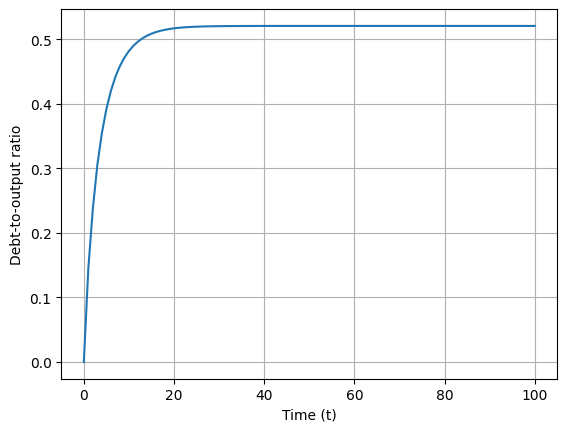

In [68]:
# Aggregate savings using the same summation:
transition_pdf_assets = transition_path_assets.sum(axis=2)
transition_assets = np.sum(a_grid[None, :] * transition_pdf_assets, axis=1)

# Aggregate endowment:
# First, stationary distribution:
pi0 = pdf_ss1.sum(axis=0)
# Then aggregate endowment:
y_agg = np.sum(pi0 * y)
print(f'Aggregate endowment: {y_agg}')

# Plot the path of debt-to-output ratio, $\frac{B_t}{Y}$
debt_output_ratio = transition_assets / y_agg
plt.plot(debt_output_ratio)
plt.xlabel('Time (t)')
plt.ylabel('Debt-to-output ratio')
plt.grid()
plt.show()

## Part j

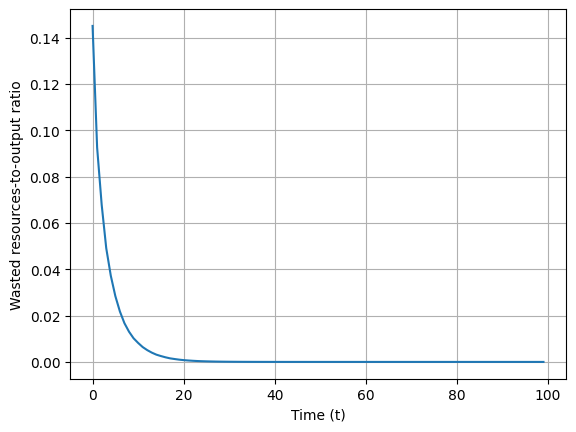

In [69]:
# resource lost: 
wasted_resources = transition_assets[1:] - R_prime * transition_assets[: -1]

## Plot path of wasted resources-to-output ratio: 

wasted_resources_output_ratio = wasted_resources / y_agg
plt.plot(wasted_resources_output_ratio)
plt.xlabel('Time (t)')
plt.ylabel('Wasted resources-to-output ratio')
plt.grid()
plt.show()

## Part k

The condition is satisfied as wasted resource is nonnegative for all t, for the whole transition. This is equivalent to have that $B_{t+1} - R_tB_t \geq 0$ for all $t$, that is, the BC of government is satisfied. 

It constitutes an equilibrium, but it's not stationary, it's special case with fixed R. All the conditions including the HHs maximizing their objective function subject to government policy and budget constraints, government budget balance holds and markets clearing condition holds as well. 

We can see from the plot in (j) that wasted resources are non-negative for the entire transition. Since $B_{t+1} - R_tB_t$ represents the wasted resources, then the plot equivalently implies that $B_{t+1} - R_tB_t \geq 0$, meaning that the budget constraint of the government is satisfied.

The transition represents an equilibrium, even though it is not stationary. Households are optimizing, government budget balance is satisfied, asset market clearing is satisfied (since we construct $B_t$ as $B_t=A_t$), and feasibility is satisfied (since wasted resources are non-negative).

## Part l

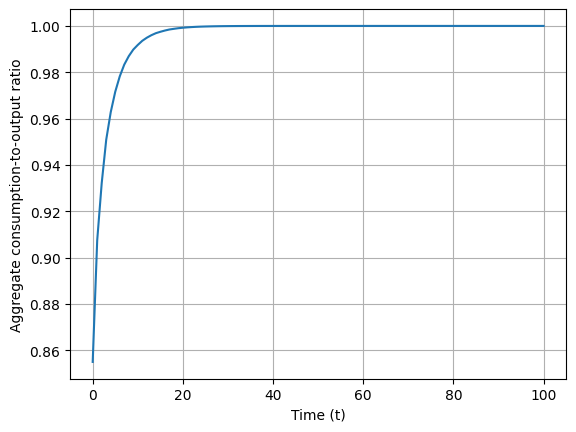

In [70]:
# Optimal consumption using the condition: c = R'a + y(s) - a':
policy_cons = R_prime * a_grid[:, None] + y[None, :] - a_grid[policy2]

# The transition path of the aggregate consumption:
transition_agg_cons = np.sum(transition_path_assets * policy_cons[None, :, :], axis=(1, 2))

# Plot the path of wasted aggregate consumption-to-output ratio:
agg_cons_output_ratio = transition_agg_cons / y_agg
plt.plot(agg_cons_output_ratio)
plt.xlabel('Time (t)')
plt.ylabel('Aggregate consumption-to-output ratio')
plt.grid()
plt.show()

Here, we plotted the time series of $C_t / Y_t$ in order to compare with the plots in parts(i) and (j).

The aggregate consumption is not equal to $Y_t$ for every $t$. Comparing the plots in (j) and (l), we see that $(C_t + B_{t+1} - R_tB_t) / Y_t = 1$, i.e. all resources are either consumed or wasted.

As for the relation with part (k), $C_t \leq Y_t$ holds for all $t$ in an equilibrium. Here, we have feasibility but not  all resources are consumed, that is, there are some wasted resources in this part.

## Part m

It is a pareto improvement. Consider the household problem, when $R$ increases, with other coefficients fixed, the household chooses the same policy as before. As a result, HHs get higher lifetime utility, $v$ is strictly higher. See
 $$
\begin{align*}
v(a, s) = \max_{a' \geq 0} \{u(Ra + y(s) - a') + \beta E v(a', s') \}
\end{align*}
$$

## Part n

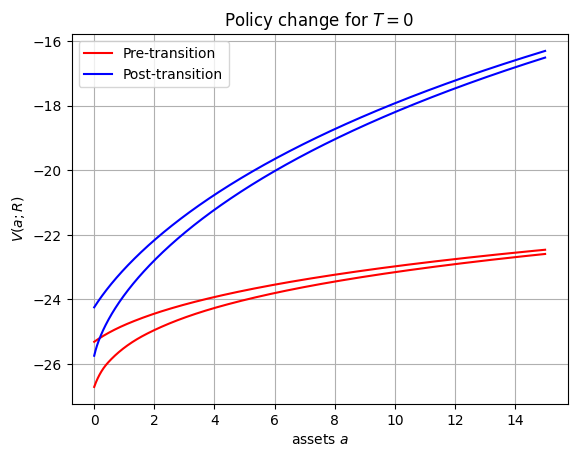

In [71]:
# Plot comparison of value functions:

# For each case (each color), different endowments are denoted by: lower curve for y=0.5, and higher curve for y=1

plt.plot(a_grid, value1[:, 0], color='r', label=r'Pre-transition') # y=0.5
plt.plot(a_grid, value1[:, 1], color='r') # y=1
plt.plot(a_grid, value2[:, 0], color='b', label=r'Post-transition') # y=0.5
plt.plot(a_grid, value2[:, 1], color='b') # y=1
plt.title(r'Policy change for $T=0$')
plt.xlabel(r'assets $a$')
plt.ylabel(r'$V(a; R)$')
plt.legend()
plt.grid()

When evaluating the welfare of a policy, we want to compare the value function at the original equilibrium to the value function at the first period of the transition to the new equilibrium.

As argued in (g), along the transition, the value function is always equivalent to the value function at the new equilibrium. So in this case, the value function at the first period of the transition equals the value function at the new equilibrium.

Therefore, can use the value function computed in part (c), which gives the value function at the new equilibrium (and equivalently at all periods along the transition, including the first period of the transition).

## Part o

Consider any Huggett model with no borrowing, $\phi = 0$. 

The aggregate resource constraint is $C_t(\{R_t = 1 \}) + A_{t+1}(\{R_t = 1 \}) \leq Y +R_t A_t(\{R_t = 1 \}), \forall t$. 

Note that with $R_t = 1 > R$, the RHS of the budget constraint is strictly higher $\forall t$. It implies that the HH are strictly better off.
If we plug in $R_t = 1$, with $A_{t+1}(\{R_t = 1 \}) \geq A_{t}(\{R_t = 1 \})$, $C_t(\{R_t = 1 \}) \leq Y + A_t(\{R_t = 1 \}) - A_{t+1}(\{R_t = 1 \}) , \forall t$, so the new plan is feasible.

## Part p


Suppose we have 
* $T$, the number of periods in the transition, can be updated in the algorithm;
* $R1$, the interest rate at the initial equilibrium 'A' before the change of the policy;
* $R2$, the interest rate at the new equilibrium 'B', after the policy changed.

Then the algorithm to compute the transition is:
1. Given $R1$, use the defined VFI and get_stationary_distribution to compute the equilibrium A

2. Given $R2$, use the defined VFI and get_stationary_distribution compute the equilibrium B 

3. Guess an initial path for transfers. One initial guess of the trasfers can be the wasted resouces by computing the trasition with no trasfers. Please note that, the initial guess cannot be zeros as it may cause some issues here

4. Given equilibia A and B, we conduct backwards iteration. Taking initial guess of transfers as given, compute the the path of value functions and policy functions from B to A. Starting from B (t=T), for any $t$, using the value function and the policy function for $t$ to solve for the policy and value functions of $t-1$ until t = 0 to get the path

5. Conduct forwards iteration by using the policy functions given in step 4 to compute the transition of the distribution of assets. Start with the policy function and value function of equilibrium A on the A's asset distribution to compute the asset distribution of period one, then use period $t$ to compute priod $t+1$, and iterate until T to get the entire trasition path

6. After forward iteration, we can update the path of transfers using the market clearing condtion $A_t=B_t$ by $T_t=B_{t+1} - R_2B_t$

7. Using the tolerance to check convergence of the distribution. Before the the tolerance condition is satisfied, repeat our process from step 4 by using the updated transfers.  



The function compute\_full\_transition is an implementation of the algorithm. 

## Part q


Roughly speaking, he value function we get in part (c) doesn't take into account of the dynamics of the economy. We need to do the policy analysis by comparing the welfare of the $v_0$ (the one we get from the end of the backward iteration) to compare with our original euilibrium A to see the only effect caused by the policy itself.

By the graph below, we need compare the blue one (the one we get from the end of the backward iteration at T = 0) with the original one (pre-transition, equilibrium A, red one). 

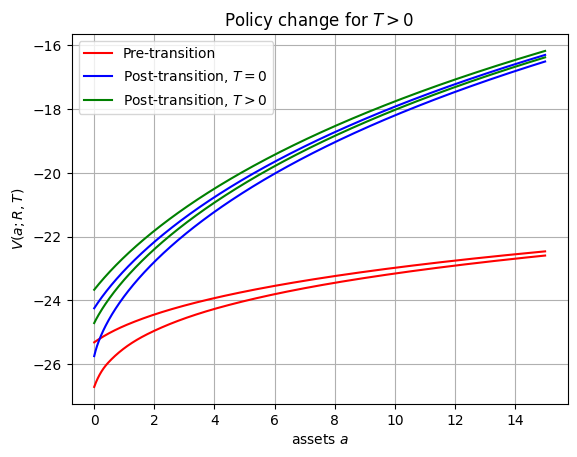

In [72]:
# Compare value functions:

# NOTE: for each color, lower line is for y=0.5 and higher line is for y=1

value3 = value_path[0, :, :]
plt.plot(a_grid, value1[:, 0], color='r', label=r'Pre-transition') # y=0.5
plt.plot(a_grid, value1[:, 1], color='r') # y=1
plt.plot(a_grid, value2[:, 0], color='b', label=r'Post-transition, $T=0$') # y=0.5
plt.plot(a_grid, value2[:, 1], color='b') # y=1
plt.plot(a_grid, value3[:, 0], color='g', label=r'Post-transition, $T>0$') # y=0.5
plt.plot(a_grid, value3[:, 1], color='g') # y=1
plt.title(r'Policy change for $T>0$')
plt.xlabel(r'assets $a$')
plt.ylabel(r'$V(a; R, T)$')
plt.legend()
plt.grid()
